In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne

from gait_modulation.file_reader import MatFileReader
from gait_modulation.data_processor import DataProcessor


# Loading the data

In [2]:
# # Use this class to handle multiple patients with nested directories.

# root_directory = '/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/data/'
# mat_reader = MatFileReader(root_directory)

# # Read all data from nested folders of multiple patients and trials
# all_data = mat_reader.read_data()

# # Example: Access specific sessions for a patient
# session1, session2 = all_data[0], all_data[1]

In [3]:
mat_files_directory = '/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/data/EM_FH_HK/PW_EM59/21_07_2023'

# mat_files_directory = '/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/data/EM_FH_HK/PW_HK59/26_10_22/MAT/'

mat_reader = MatFileReader(mat_files_directory)
data = mat_reader.read_data()
session4, session3 = data[0], data[1]

session = session3
session.keys()

Loading data from file: EM_FH_HK/PW_EM59/21_07_2023/walking_sync_4_short.mat
Loading data from file: EM_FH_HK/PW_EM59/21_07_2023/walking_sync_3_short.mat


dict_keys(['data_acc', 'data_EEG', 'data_EMG', 'data_giro', 'data_LFP', 'dir', 'events_KIN', 'events_STEPS', 'filename_mat', 'hdr_EEG', 'hdr_EMG', 'hdr_IMU', 'hdr_LFP', 'pt', 'session'])

In [4]:
# extract events and lfp data of the subject/session
lfp_data = session['data_LFP']
lfp_metadata = DataProcessor.np_to_dict(session['hdr_LFP'])
events_KIN = DataProcessor.np_to_dict(session['events_KIN'])

lfp_data.shape

(6, 43382)

In [5]:
lfp_ch_names = DataProcessor.rename_lfp_channels(lfp_metadata['labels'])
lfp_n_channels = lfp_metadata['NumberOfChannels'].item()
lfp_sfreq = lfp_metadata['Fs'].item()
lfp_duration = lfp_data.shape[1] / lfp_sfreq
lfp_sample_length = int(lfp_duration * lfp_sfreq) # TODO: Trim the data

lfp_data.shape, lfp_duration, lfp_sfreq, lfp_ch_names, lfp_sample_length

((6, 43382),
 173.528,
 250,
 ['LFP_L03', 'LFP_L13', 'LFP_L02', 'LFP_R03', 'LFP_R13', 'LFP_R02'],
 43382)

In [6]:
# Check if the LFP data starts before the first event (that indicates when the first trials starts) 
# DataProcessor.check_lfp_start(lfp_data, events_KIN, lfp_sfreq)

In [7]:
lfp_data *= 1e-6 # Convert microvolts to volts


# Prepare for mne data structure

Creating RawArray with float64 data, n_channels=6, n_times=43382
    Range : 0 ... 43381 =      0.000 ...   173.524 secs
Ready.
Using matplotlib as 2D backend.


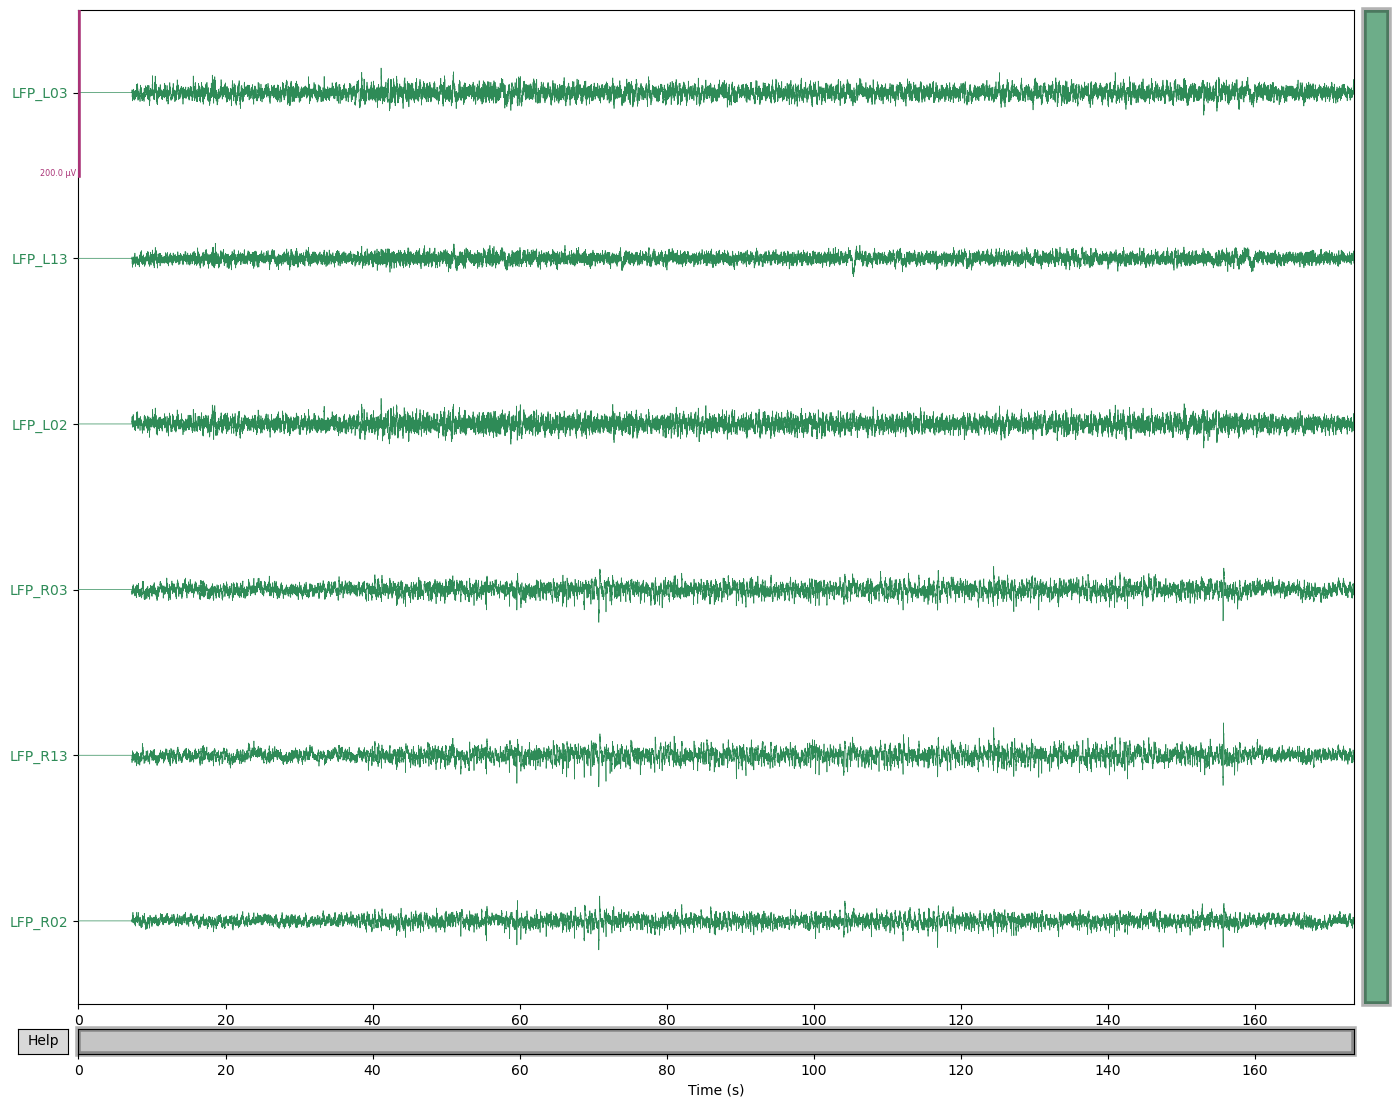

In [8]:
info = mne.create_info(ch_names=lfp_ch_names[0:6], sfreq=lfp_sfreq, ch_types='dbs')
lfp_raw = mne.io.RawArray(lfp_data, info)
lfp_raw.plot(start=0, duration=np.inf, remove_dc=False) 
plt.show()

# Handle events

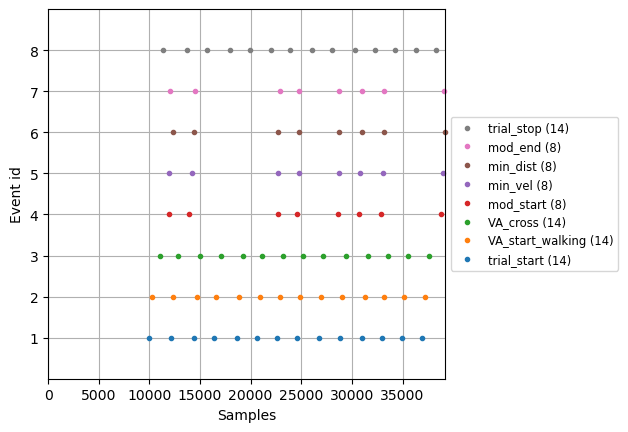

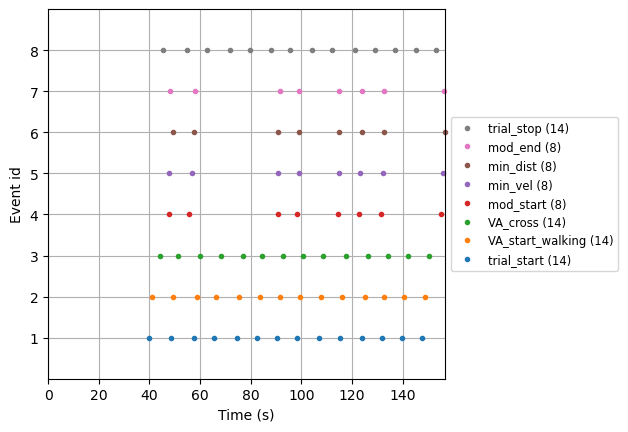

In [9]:
events, event_dict = DataProcessor.create_events_array(events_KIN, lfp_sfreq)

mne.viz.plot_events(events, event_id=event_dict)
mne.viz.plot_events(events, sfreq=lfp_sfreq, event_id=event_dict)
plt.show()

In [10]:
event_dict

{'trial_start': 1,
 'VA_start_walking': 2,
 'VA_cross': 3,
 'mod_start': 4,
 'min_vel': 5,
 'min_dist': 6,
 'mod_end': 7,
 'trial_stop': 8}

## Extract the event-related

In [11]:
# Select one event to work with: mod_start
event_of_interest = 'mod_start'
events_mod_start = events[events[:, 2] == event_dict[event_of_interest]]

# Rename Gait Modulation Events
gait_modulation_event_id = 1
events_mod_start[:,2] = gait_modulation_event_id

In [12]:
# test the shape of the events
not_nans = np.count_nonzero(~np.isnan(events_KIN['times']))
nans = np.count_nonzero(np.isnan(events_KIN['times'])) 
flatten = events_KIN['times'].flatten().shape[0]

print(not_nans, nans, not_nans + nans, flatten)
print(events.shape)

88 24 112 112
(88, 3)


### Define Normal Walking Events
1. Extract Epochs Around Modulation Events: First, extract epochs centered around modulation events to ensure we capture relevant data around these events.
   
2.	Remove Invalid Gaps: After extracting epochs around modulation events, filter out epochs that are within invalid gaps (less than 10 seconds between modulation epochs and normal walking epochs).

3.	Assign Resting Data to Normal Walking Epochs: Use the remaining periods to extract normal walking epochs that are valid and not too close to modulation events.

In [13]:
# Define parameters
epoch_tmin = -2.0
epoch_tmax = 0.0
epoch_duration_length = epoch_tmax - epoch_tmin
epoch_sample_length = int(epoch_duration_length * lfp_sfreq)
gap_duration = 10   # At least 10 seconds away from modulation events
gap_sample_length = int(gap_duration * lfp_sfreq)
n_samples = lfp_data.shape[1]

In [14]:
# Define Normal Walking Events
# Calculate gap boundaries (before and after each modulation event)
gap_boundaries = np.column_stack(
    (events_mod_start[:, 0] - gap_sample_length,
     events_mod_start[:, 0] + gap_sample_length)
)

# Construct the output array
normal_walking_ranges = np.vstack((
    np.array([500, gap_boundaries[0, 0]]),  # First interval
    np.column_stack((gap_boundaries[:-1, 1], gap_boundaries[1:, 0])),  # Middle intervals
    np.array([gap_boundaries[-1, 1], n_samples])  # Last interval
))

# Make sure that we don't generate events in the gap areas.
# Create a boolean mask where first column <= second column
mask = normal_walking_ranges[:, 0] <= normal_walking_ranges[:, 1]

# Apply the mask to remove rows where the first column > second column
normal_walking_ranges = normal_walking_ranges[mask]

walking_onsets = np.concatenate(
    [np.arange(boundary[0], boundary[1] + epoch_sample_length, epoch_sample_length) for boundary in normal_walking_ranges]
)

# Create the normal walking event array
normal_walking_event_id = -1
normal_walking_events = np.column_stack((
    walking_onsets.astype(int),
    np.zeros_like(walking_onsets, dtype=int),
    np.ones_like(walking_onsets, dtype=int) * normal_walking_event_id))

In [15]:
# Combine modulation and normal walking events
events = np.vstack((events_mod_start, normal_walking_events))
events = events[np.argsort(events[:, 0])]  # Sort events by onset time
events_id = {'mod_start': gait_modulation_event_id,
             'normal_walking': normal_walking_event_id}

# Create Epochs
epochs = mne.Epochs(
    lfp_raw,
    events,
    events_id,
    epoch_tmin,
    epoch_tmax,
    baseline=None,
    preload=True,
)

# Print some details
print(f"Epochs info: {epochs}")
print(f"Number of epochs: {len(epochs)}")

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 501 original time points ...
1 bad epochs dropped
Epochs info: <Epochs |  44 events (all good), -2 – 0 s, baseline off, ~1.0 MB, data loaded,
 'mod_start': 8
 'normal_walking': 36>
Number of epochs: 44


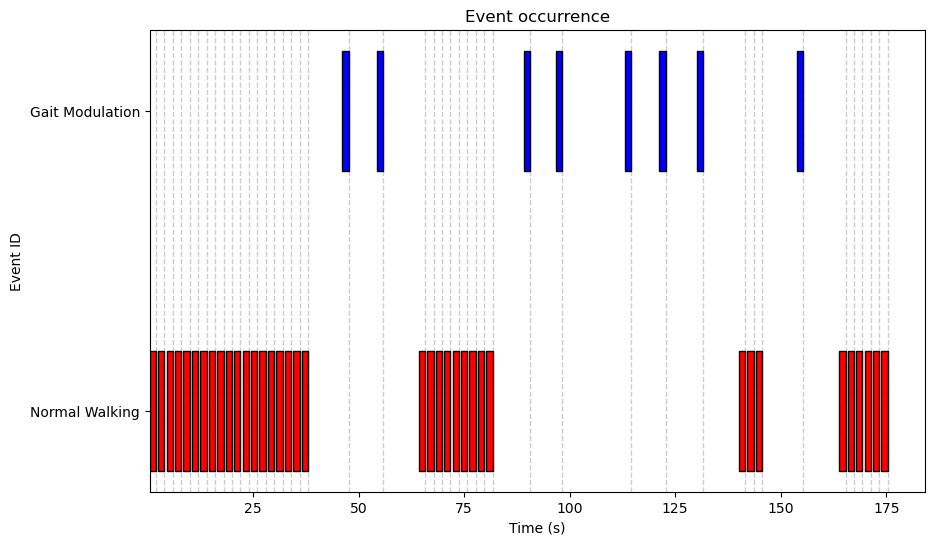

In [16]:
# Parameters for plotting
events_time = events[:, 0] / lfp_sfreq
event_ids = events[:, 2]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
for onset, event_id in zip(events_time, event_ids):
    start = onset - epoch_sample_length/1000  # 500 ms before the onset
    end = onset
    color = 'blue' if event_id == gait_modulation_event_id else 'red'
    ax.barh(event_id, width=3*(end - start), left=start-1, color=color, edgecolor='black')

# Plot dashed lines for onsets
for onset in events_time:
    ax.axvline(x=onset, color='black', linestyle='--', linewidth=1,  alpha=0.2)

# Configure plot
ax.set_xlabel('Time (s)')
ax.set_ylabel('Event ID')
ax.set_yticks([gait_modulation_event_id, normal_walking_event_id])
ax.set_yticklabels(['Gait Modulation', 'Normal Walking'])
ax.set_title('Event occurrence')
plt.show()

In [18]:


# # Parameters for plotting
# sfreq = 250  # Sampling frequency (Hz)
# events_time = events[:, 0] / sfreq
# event_ids = events[:, 2]

# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot bars for both events on the same level (y=1)
# for onset, event_id in zip(events_time, event_ids):
#     start = onset - 0.5  # 500 ms before the onset
#     end = onset
#     color = 'blue' if event_id == gait_modulation_event_id else 'red'
#     ax.barh(1, width=end - start, height= 0.1, left=start, color=color, edgecolor=color)

# # Plot dashed lines for onsets
# for onset in events_time:
#     ax.axvline(x=onset, color='black', linestyle='--', linewidth=0.3)

# # Add legend for event types
# legend_labels = ['Gait Modulation', 'Normal Walking']
# colors = ['blue', 'red']
# handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
# ax.legend(handles, legend_labels, loc='upper right')

# # Configure plot
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Events')
# ax.set_yticks([])
# # ax.set_yticklabels(['Events'])
# ax.set_title('Event Bars with Dashed Lines for Onsets and Legend')

# # Show plot
# plt.show()

In [18]:
(epochs.get_data().shape[0], epochs.get_data().shape[2]), events.shape[0], lfp_sfreq, epoch_tmax-epoch_tmin, events.shape[0]

/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56036/179249566.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  (epochs.get_data().shape[0], epochs.get_data().shape[2]), events.shape[0], lfp_sfreq, epoch_tmax-epoch_tmin, events.shape[0]
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56036/179249566.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  (epochs.get_data().shape[0], epochs.get_data().shape[2]), events.shape[0], lfp_sfreq, epoch_tmax-epoch_tmin, events.shape[0]


((44, 501), 45, 250, 2.0, 45)

In [19]:
# TODO: test this!
# assert epochs.get_data().shape[0] * epochs.get_data().shape[2] == events.shape[0] * lfp_sfreq * (epoch_tmax-epoch_tmin) + events.shape[0] # 0.4 = tmax - tmin

print(epochs.get_data().shape[0] * epochs.get_data().shape[2])
print(events.shape[0] * lfp_sfreq * (epoch_tmax-epoch_tmin) + events.shape[0]) # 0.4 = tmax - tmin

22044
22545.0


/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56125/4114963466.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(epochs.get_data().shape[0] * epochs.get_data().shape[2])
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56125/4114963466.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(epochs.get_data().shape[0] * epochs.get_data().shape[2])


# Pre-Processing

In [20]:
# Extract the data from the Epochs object (X) and the corresponding labels (y)
X = epochs.get_data(copy=True)
y = epochs.events[:, -1]

print(f'X shape: {X.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y shape: {y.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(X)}, with {sum(y == -1)} normal walking and {sum(y == 1)} event-related gait modulation')

X shape: (44, 6, 501)
y shape: (44,)
--- Total epochs: 44, with 36 normal walking and 8 event-related gait modulation


In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# Step 1: Flatten the X array (n_epochs, n_channels, n_samples_per_epoch) -> (n_epochs, n_channels * n_samples_per_epoch)
n_epochs, n_channels, n_samples_per_epoch = X.shape
X_flat = X.reshape(n_epochs, n_channels * n_samples_per_epoch)

# Step 2: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Standardize the features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train a Logistic Regression model
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Step 5: Make predictions
y_pred = clf.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output the results
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.7778
Confusion Matrix:
[[7 0]
 [2 0]]


# Filtering the data

Effective window size : 8.192 (s)
PSD data has shape: (6, 410)  # channels x frequencies
Frequencies has shape: (410,)  # frequencies
Plotting power spectral density (dB=True).


/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56125/1762076618.py:10: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  spectrum.plot()
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56125/1762076618.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot()
/Users/orabe/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


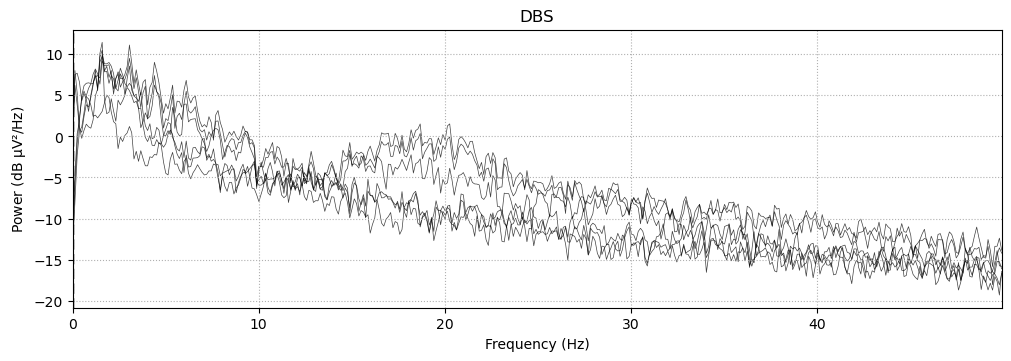

In [22]:
# raw psd
spectrum = lfp_raw.compute_psd(method='welch', fmax=50, n_fft=2048)

psd_arr = spectrum.get_data()
psd_freqs = spectrum.freqs

print(f"PSD data has shape: {psd_arr.shape}  # channels x frequencies")
print(f"Frequencies has shape: {psd_freqs.shape}  # frequencies")

spectrum.plot()

Effective window size : 2.004 (s)
PSD data has shape: (44, 6, 101)  # channels x frequencies
Frequencies has shape: (101,)  # frequencies
Plotting power spectral density (dB=True).
Averaging across epochs...


/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56125/1999376867.py:2: UserWarning: Zero value in spectrum for channels LFP_L03, LFP_L13, LFP_L02, LFP_R03, LFP_R13, LFP_R02
  spectrum = epochs.compute_psd(method='welch', fmax=50)
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56125/1999376867.py:10: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  spectrum.plot()
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56125/1999376867.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot()
/Users/orabe/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


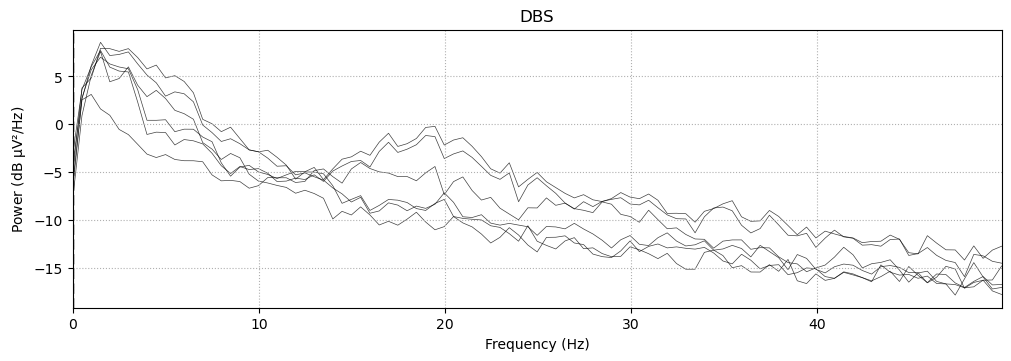

In [24]:
# epochs psd
spectrum = epochs.compute_psd(method='welch', fmax=50)

psd_arr = spectrum.get_data()
psd_freqs = spectrum.freqs

print(f"PSD data has shape: {psd_arr.shape}  # channels x frequencies")
print(f"Frequencies has shape: {psd_freqs.shape}  # frequencies")

spectrum.plot()

In [25]:
lfp_raw.filter(l_freq = 1, h_freq=None)
# raw_copy.notch_filter(freqs=[5, 10, 20])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,6 DBS
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,125.00 Hz


Effective window size : 8.192 (s)
PSD data has shape: (6, 410)  # channels x frequencies
Frequencies has shape: (410,)  # frequencies
Plotting power spectral density (dB=True).


/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56125/3209174340.py:9: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  spectrum.plot()
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56125/3209174340.py:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot()
/Users/orabe/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


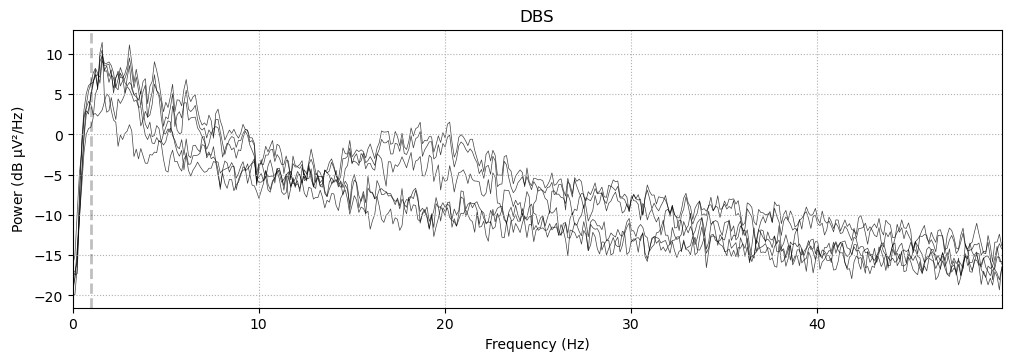

In [26]:
spectrum = lfp_raw.compute_psd(method='welch', fmax=50, n_fft=2048)

psd_arr = spectrum.get_data()
psd_freqs = spectrum.freqs

print(f"PSD data has shape: {psd_arr.shape}  # channels x frequencies")
print(f"Frequencies has shape: {psd_freqs.shape}  # frequencies")

spectrum.plot()

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56125/1476008197.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  lfp_raw.compute_psd(method='welch', fmax=50, n_fft=2048).plot()
/var/folders/jk/skjgj9ps5xs02bklf7l0nsjr0000gn/T/ipykernel_56125/1476008197.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  lfp_raw.compute_psd(method='welch', fmax=50, n_fft=2048).plot()
/Users/orabe/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


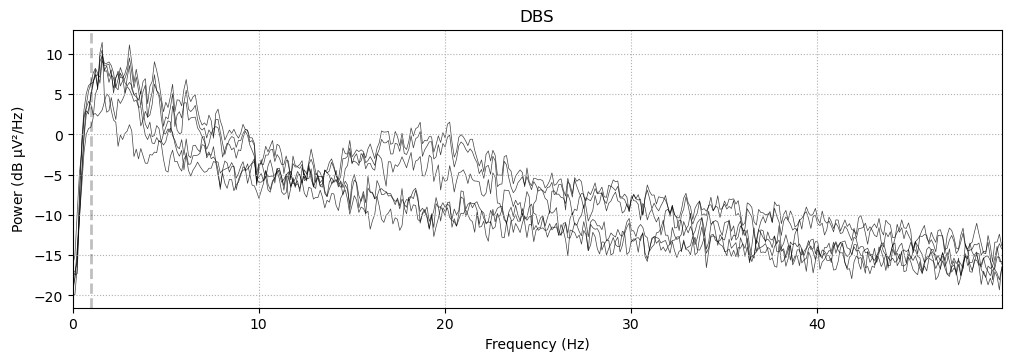

In [27]:
lfp_raw.compute_psd(method='welch', fmax=50, n_fft=2048).plot()


In [28]:
# ICA raw
## CODE GOES HERE
ica_95PCA = mne.preprocessing.ICA(n_components=0.95, random_state=0)
ica_95PCA.fit(inst=lfp_raw)
# ica_95PCA.plot_sources(inst=lfp_raw, title="ICA sources (95% variance PCA components)");

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by explained variance: 4 components
Fitting ICA took 0.1s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,24 iterations on raw data (43382 samples)
ICA components,4
Available PCA components,6
Channel types,dbs
ICA components marked for exclusion,—


In [ ]:
# raw_ica_excluded = ica.apply(inst=lfp_raw.copy())
# raw_ica = ica.apply(inst=lfp_raw.copy())

# raw_ica_excluded.plot(scalings='auto', start=12, duration=4, title='clraned sensor signals (without noise)')
# raw_ica.plot(scalings='auto', start=12, duration=4, title='clraned sensor signals (without noise)')

In [ ]:
# # ICA rpochs
# ## CODE GOES HERE
# ica_95PCA = mne.preprocessing.ICA(n_components=0.95, random_state=0)
# ica_95PCA.fit(inst=epochs_raw)
# ica_95PCA.plot_sources(inst=epochs_raw, title="ICA sources (95% variance PCA components)");

In [ ]:
# # Compute variance explained by PCA components
# explained_variance = ica.pca_explained_variance_ / np.sum(ica.pca_explained_variance_)

# print(f"Variance explained by PCA components: {explained_variance}")
# print(f"Variance explained by first 4 PCA components: {np.sum(explained_variance[:4]) * 100:.2f}%")

In [ ]:
# ica = mne.preprocessing.ICA(random_state=0)
# ica.fit(raw_sensors)

# # Remove the first ICA component (the random noise) from the data
# raw_cleaned = ica.apply(inst=raw_sensors.copy(), exclude=[1,2])
# raw_cleaned.plot(scalings='auto', title='clraned sensor signals (without noise)')

In [ ]:
# from sklearn.manifold import spectral_embedding  # noqa
# from sklearn.metrics.pairwise import rbf_kernel  # noqa

# def order_func(times, data):
#     this_data = data[:, (times > epoch_tmin) & (times < epoch_tmax)]
#     this_data /= np.sqrt(np.sum(this_data**2, axis=1))[:, np.newaxis]
#     return np.argsort(
#         spectral_embedding(
#             rbf_kernel(this_data, gamma=1.0), n_components=1, random_state=0
#         ).ravel()
#     )



# # We'll also plot a sample time onset for each trial
# plt_times = np.linspace(0, 0.2, len(epochs_raw['trial_start']))

# plt.close("all")
# mne.viz.plot_epochs_image(
#     epochs_raw['trial_start'],
#     [0, 1],
#     sigma=0.5,
#     order=order_func,
#     # vmin=-250,
#     # vmax=250,
#     overlay_times=plt_times,
#     show=True,
# )



In [29]:
epochs_raw["mod_start"].plot_image(combine="mean");

NameError: name 'epochs_raw' is not defined

In [30]:
mne.viz.plot_epochs_image(
    epochs_raw['mod_start'],
    picks=[0, 1, 2, 3, 4, 5],
    sigma=0.5,
    # combine="mean",
    # evoked=True
)

NameError: name 'epochs_raw' is not defined

# Evoked

evoked_0 = epochs_raw['trial_start'].average()
evoked_4 = epochs_raw['mod_start'].average()

## Global Field Power (GFP)

The GFP is the population standard deviation of the signal across channels.

In [ ]:
fig0 = evoked_0.plot(gfp=True);
fig1 = evoked_1.plot(gfp=True);

In [ ]:
evoked_0.plot(gfp="only");
evoked_1.plot(gfp="only");

In [ ]:
gfp = evoked_0.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(evoked_0.times, gfp * 1e6, color="lime")
ax.fill_between(evoked_0.times, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (s)", ylabel="GFP (µV)")

In [ ]:
gfp = evoked_1.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(evoked_1.times, gfp * 1e6, color="lime")
ax.fill_between(evoked_1.times, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (s)", ylabel="GFP (µV)")

# # Time-frequency analysis

In [ ]:
freqs = np.arange(2, 50, 2) # Frequencies from 2 to 50 Hz
n_cycles = freqs / 2 # Number of cycles in Morlet wavelet


In [ ]:
freqs = np.arange(7, 30, 3)
power = epochs_raw['mod_start'].compute_tfr(
    "morlet", 
    n_cycles=2,
    return_itc=False, 
    freqs=freqs,
    decim=3,
    average=True
)
power.plot(title='auto')

In [ ]:
freqs = np.arange(7, 30, 3)
power = epochs_raw['min_vel'].compute_tfr(
    "morlet", 
    n_cycles=2,
    return_itc=False, 
    freqs=freqs,
    decim=3,
    average=True
)
power.plot(title='auto')

# CSD

In [ ]:
csd_fft = mne.time_frequency.csd_fourier(epochs_raw, fmin=1, fmax=70)
csd_mt = mne.time_frequency.csd_multitaper(epochs_raw, fmin=1, fmax=70, adaptive=True)
frequencies = np.arange(1,71, 1)
csd_wav = mne.time_frequency.csd_morlet(epochs_raw, frequencies, decim=1)

In [ ]:
plot_dict = {
    "Short-time Fourier transform": csd_fft,
    "Adaptive multitapers": csd_mt,
    "Morlet wavelet transform": csd_wav,
}
for title, csd in plot_dict.items():
    (fig,) = csd.mean().plot()
    fig.suptitle(title)